In [1]:
import numpy as np
import numpy.random as rnd
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import optimizers, Variable
import matplotlib.pyplot as plt
from copy import deepcopy

In [24]:
seed = 0
innerstepsize = 0.02
innerepochs = 1
outerstepsize0 = 0.1
niterations = 30000 

In [3]:
rnd.seed(0)

In [4]:
x_all = np.linspace(-5, 5, 50, dtype='f')[:,None]
ntrain = 10

In [5]:
model = chainer.Sequential(
    L.Linear(1, 64),
    F.tanh,
    L.Linear(64, 64),
    F.tanh,
    L.Linear(64, 1)
)
#opt = optimizers.Adam(alpha=outerstepsize0)
opt = optimizers.SGD(lr=outerstepsize0)
opt.setup(model)

In [6]:
def gen_task():
    phase = rnd.uniform(0, 2 * np.pi)
    ampl = rnd.uniform(0.1, 5)
    sin_t = lambda x: np.sin(x + phase) * ampl
    return sin_t

In [7]:
def inner_train(x, y, model):
    x = Variable(x)
    y = Variable(y)
    model.zerograds()
    ypred = model(x)
    err = (ypred - y) ** 2
    loss = F.mean(err)
    loss.backward()
    for param in model.params():
        param.data -= innerstepsize * param.grad

In [8]:
def meta_train():
    cp_model = deepcopy(model)
    f = gen_task()
    y_all = f(x_all)
    inds = rnd.permutation(len(x_all))
    for _ in range(innerepochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            inner_train(x_all[mbinds], y_all[mbinds], cp_model)
    for param, param_cp in zip(model.params(), cp_model.params()):
        param.grad = (param.data - param_cp.data) * (1 - iteration / niterations)
    opt.update()

In [9]:
def predict(x, model):
    x = Variable(x)
    with chainer.no_backprop_mode():
        return model(x).data

def performance_check(model, N=32):
    xtrain_plot = x_all[rnd.choice(len(x_all), size=ntrain)]
    f = gen_task()
    plt.plot(x_all, predict(x_all, model), label="pred after 0", color=(0,0,1))
    for inneriter in range(N):
        inner_train(xtrain_plot, f(xtrain_plot), model)
        if (inneriter+1) % (N // 4) == 0:
            frac = (inneriter+1) / N
            plt.plot(x_all, predict(x_all, model), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
    plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
    lossval = np.square(predict(x_all, model) - f(x_all)).mean()
    plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
    plt.ylim(-4,4)
    plt.legend(loc="lower right")
    return lossval

1 1.4044561


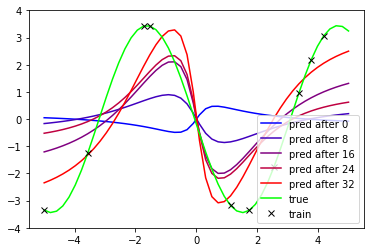

1000 1.2183244


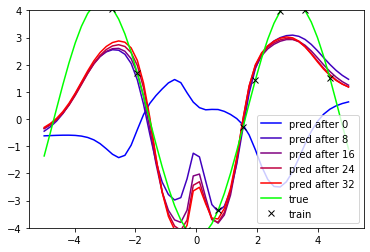

2000 0.022360096


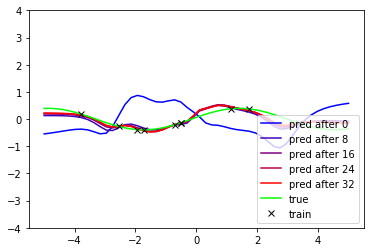

3000 0.11344109


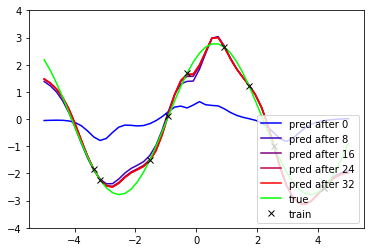

4000 0.12733546


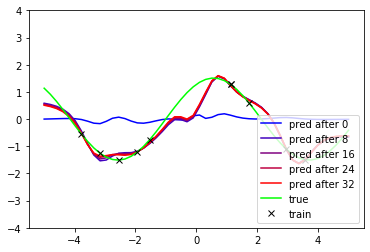

5000 0.49903974


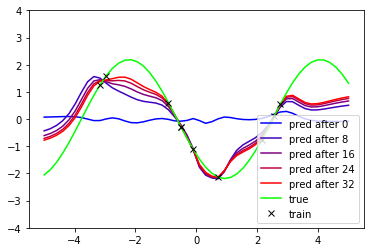

6000 0.6129169


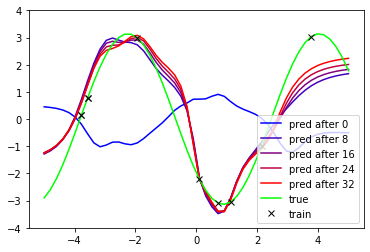

7000 0.06599216


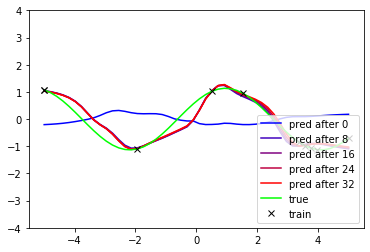

8000 0.12995858


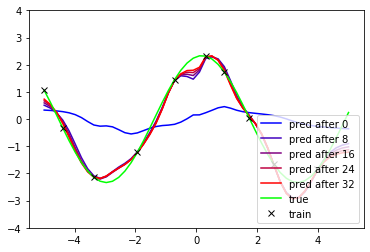

9000 0.09296236


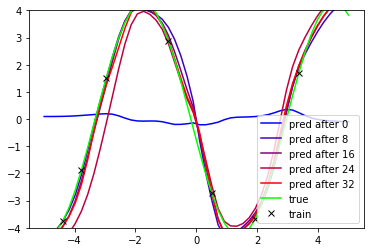

10000 0.19760588


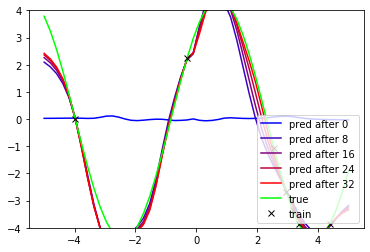

In [10]:
for iteration in range(niterations):
    meta_train()
    if iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        lossval = performance_check(deepcopy(model))
        print(iteration + 1, lossval)
        plt.pause(0.01)

0.0066449554

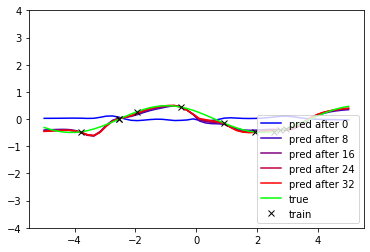

In [23]:
cp_model = deepcopy(model)
performance_check(cp_model, 32)